In [6]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime 
import yfinance as yf

In [10]:
start = pd.to_datetime('2012-01-01')
end = datetime.now()
stocks=[]

In [7]:
def import_data(ticker, start, end):
    df=yf.download(ticker, start, end)
    df=df['Adj Close']
    df= df.to_frame()
    stocks.append(df)
    return df

aapl = import_data('AAPL', start, end)
ibm = import_data('IBM', start, end)
amzn = import_data('AMZN', start, end)
cisco = import_data('CSCO', start, end)
google = import_data('GOOG', start, end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [15]:
stocks = pd.concat([aapl,ibm,amzn,cisco,google], axis=1)
stocks.columns = ['aapl','ibm','amzn','cisco','google']

In [17]:
stocks.pct_change(1).mean()

aapl      0.001068
ibm       0.000242
amzn      0.001153
cisco     0.000579
google    0.000872
dtype: float64

In [18]:
stocks.pct_change(1).corr()

,aapl,ibm,amzn,cisco,google
aapl,1.000000,0.382007,0.479567,0.475020,0.550737
ibm,0.382007,1.000000,0.280178,0.512901,0.383482
amzn,0.479567,0.280178,1.000000,0.381296,0.609216
cisco,0.475020,0.512901,0.381296,1.000000,0.452267
google,0.550737,0.383482,0.609216,0.452267,1.000000


In [19]:
stocks.pct_change(1).head()

,aapl,ibm,amzn,cisco,google
Date,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN
2012-01-04,0.005374,-0.004080,-0.008490,0.019324,0.004313
2012-01-05,0.011102,-0.004743,0.000563,-0.003687,-0.013871
2012-01-06,0.010453,-0.011481,0.028152,-0.003700,-0.013642
2012-01-09,-0.001586,-0.005205,-0.022178,0.006366,-0.042399


In [20]:
log_ret=np.log(stocks/stocks.shift(1))

In [22]:
log_ret.head()

,aapl,ibm,amzn,cisco,google
Date,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN
2012-01-04,0.005360,-0.004088,-0.008526,0.019140,0.004304
2012-01-05,0.011041,-0.004754,0.000563,-0.003693,-0.013969
2012-01-06,0.010399,-0.011547,0.027763,-0.003706,-0.013735
2012-01-09,-0.001587,-0.005218,-0.022428,0.006345,-0.043324


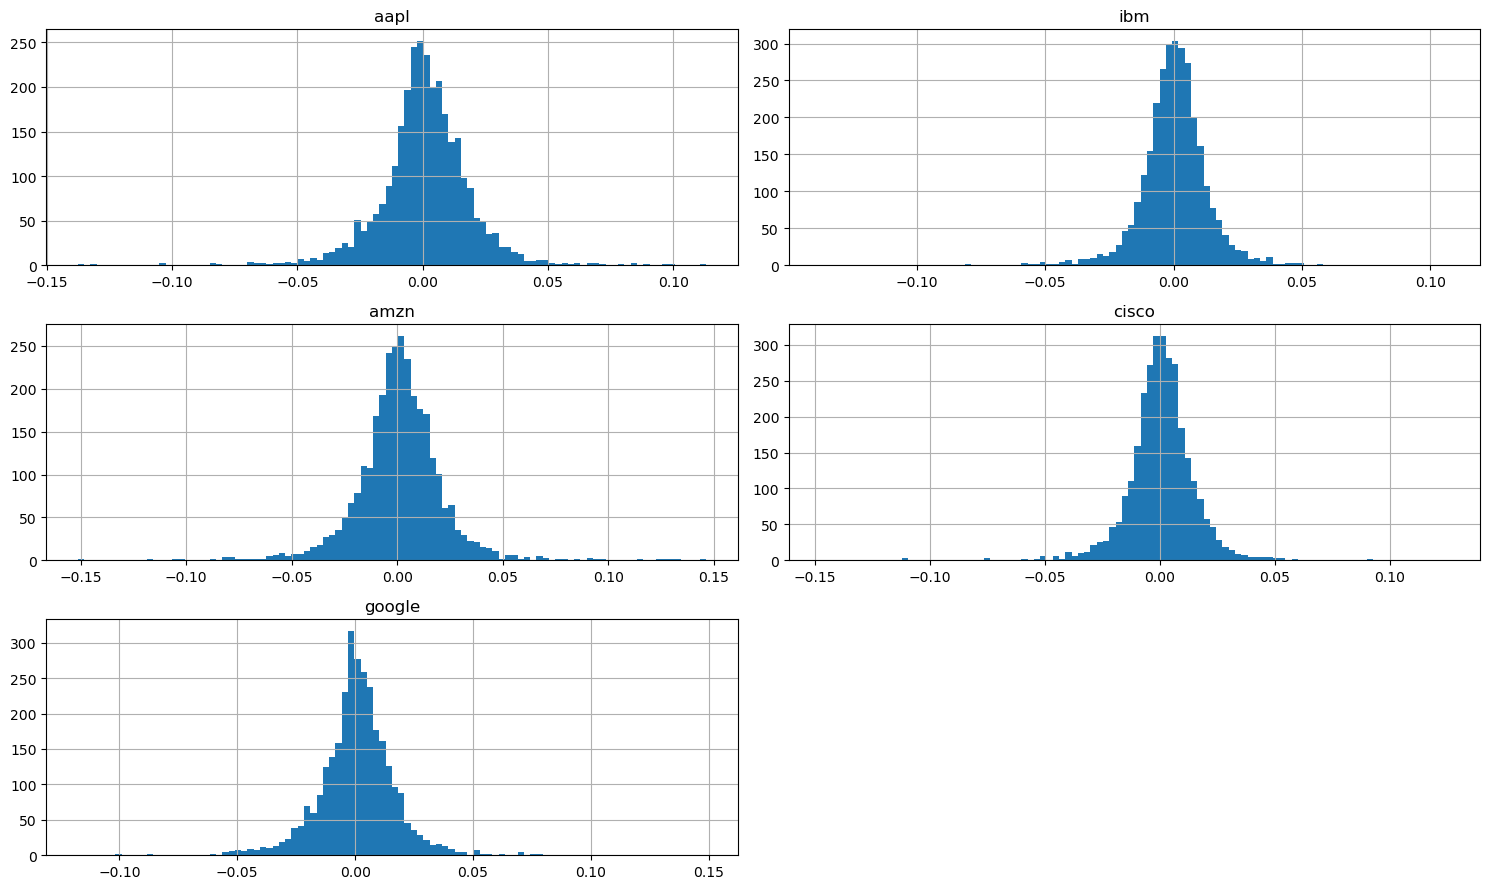

In [24]:
log_ret.hist(bins=100 , figsize=(15,9))
plt.tight_layout()

In [27]:
log_ret.cov()*252

,aapl,ibm,amzn,cisco,google
aapl,0.081136,0.024501,0.044443,0.033806,0.042543
ibm,0.024501,0.050613,0.020577,0.028836,0.023355
amzn,0.044443,0.020577,0.105057,0.031077,0.053557
cisco,0.033806,0.028836,0.031077,0.062759,0.030622
google,0.042543,0.023355,0.053557,0.030622,0.072799


In [37]:
print(stocks.columns)

Index(['aapl', 'ibm', 'amzn', 'cisco', 'google'], dtype='object')


In [48]:
np.random.seed(4)

num_ports = 5000
all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    
    #poids
    #print('Pondération aléatoire')
    weights = np.array(np.random.random(len(stocks.columns)))
    #print(weights)

    #sauvegarde des poids
    all_weights[ind,:] = weights
    
    #print('(re)Pondération des poids')
    weights = weights / np.sum(weights)
    #print(weights)

    #rendement attendu 

    #print('Rendement attendu du PTF')
    ret_arr[ind] = np.sum(log_ret.mean() * weights * 252)
    #print(exp_ret)

    # volatilité attentu 

    #print('Volatitlité attendue')
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    #print(exp_vol)

    #Ratio de Sharpe
    #print('Ratio de Sharpe')
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind] 
    #print(SR)

In [49]:
sharpe_arr.max()

0.8975682214268617

In [51]:
sharpe_arr.argmax()

3520

In [52]:
all_weights[sharpe_arr.argmax(),:]

array([0.76351642, 0.0049697 , 0.56626578, 0.05556385, 0.36437906])

In [56]:
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

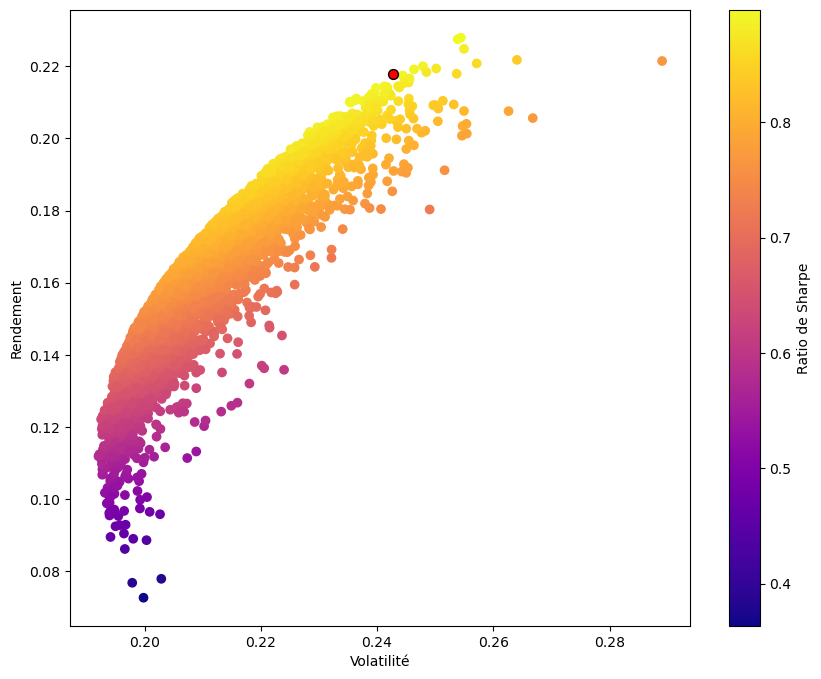

In [57]:
plt.figure(figsize=(10,8))
plt.scatter(vol_arr,ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Ratio de Sharpe')
plt.xlabel('Volatilité')
plt.ylabel('Rendement')

plt.scatter(max_sr_vol ,max_sr_ret, c='red', s=50, edgecolors='black')

In [82]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    sr = ret/vol
    
    return np.array([ret, vol, sr])

In [83]:
from scipy.optimize import minimize

In [84]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2]* -1

In [85]:
def check_sum(weights):
    #retourne 0 si la somme des poids vaut 1
    return np.sum(weights) -1

In [86]:
cons = ({'type':'eq', 'fun':check_sum})

In [94]:
bounds = ((0,1), (0,1) , (0,1)  , (0,1), (0,1))

In [95]:
init_guess = [0.25,0.25,0.25,0.25,0.25]

In [96]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [97]:
opt_results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.9011218206521694
       x: [ 5.198e-01  1.420e-17  3.305e-01  0.000e+00  1.497e-01]
     nit: 6
     jac: [ 2.242e-04  1.897e-01 -3.203e-04  1.038e-02 -7.145e-05]
    nfev: 36
    njev: 6

In [98]:
opt_results.x

array([5.19847447e-01, 1.42030485e-17, 3.30457868e-01, 0.00000000e+00,
       1.49694684e-01])

In [99]:
get_ret_vol_sr(opt_results.x)

array([0.22477483, 0.2494389 , 0.90112182])

In [104]:
frontiere_y = np.linspace(0,0.3,100)

In [105]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [106]:
frontiere_volatility = []

for possible_return in frontiere_y:
    cons = ({'type':'eq','fun':check_sum},{'type':'eq','fun':lambda w:get_ret_vol_sr(w)[0] - possible_return})
    result = minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontiere_volatility.append(result['fun'])

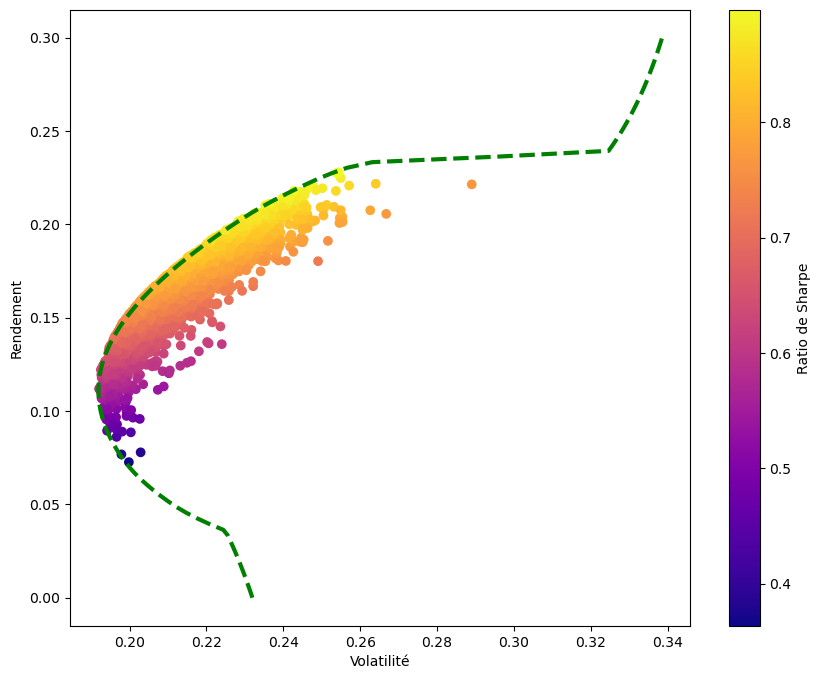

In [108]:
plt.figure(figsize=(10,8))
plt.scatter(vol_arr,ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Ratio de Sharpe')
plt.xlabel('Volatilité')
plt.ylabel('Rendement')

plt.plot(frontiere_volatility,frontiere_y, 'g--', linewidth=3)